In [1]:
# Hello Python Notebook
print('Hello Python')
%matplotlib inline

"""
Fashion MNIST CNN Classifier
A complete pipeline for training and using a CNN on Fashion MNIST dataset.
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import os

def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = get_device()
print("device:", device)

# Optional: speed on Apple Silicon
torch.set_float32_matmul_precision("high")

# Fashion MNIST class names
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# ============================================================================
# STEP 1: Download the Fashion MNIST dataset
# ============================================================================
print("\n" + "="*60)
print("STEP 1: Downloading Fashion MNIST Dataset")
print("="*60)

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download training and test datasets
train_full_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"Training set size: {len(train_full_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Hello Python
device: mps

STEP 1: Downloading Fashion MNIST Dataset


100%|████████████████████████████████████| 26421880/26421880 [00:14<00:00, 1877452.18it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|███████████████████████████████████████████| 29515/29515 [00:00<00:00, 362183.03it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████████| 4422102/4422102 [00:01<00:00, 2700759.31it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5373886.76it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set size: 60000
Test set size: 10000



STEP 2: Visualizing Samples from Each Category


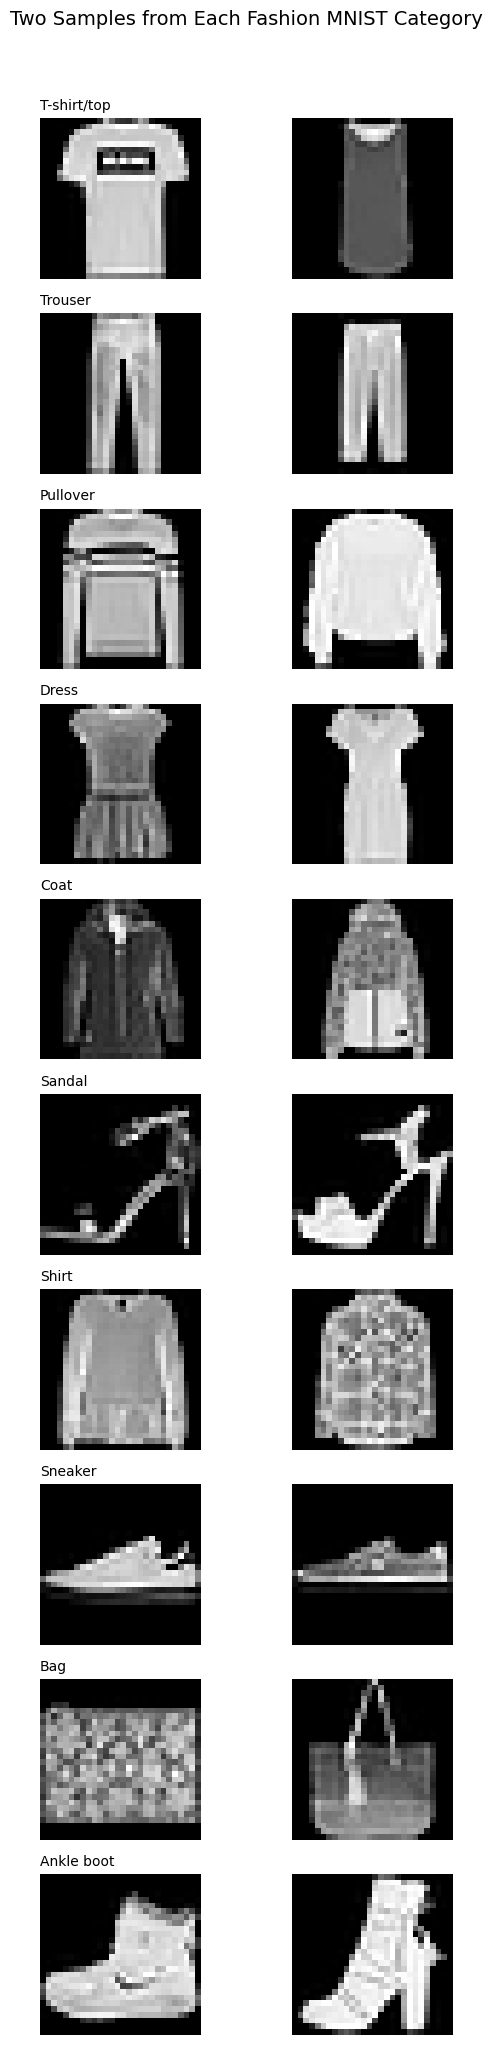

In [2]:
# ============================================================================
# STEP 2: Visualize two samples from each category
# ============================================================================
print("\n" + "="*60)
print("STEP 2: Visualizing Samples from Each Category")
print("="*60)

# Get raw dataset without normalization for visualization
raw_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

# Find two samples for each class
samples_per_class = {i: [] for i in range(10)}
for idx, (img, label) in enumerate(raw_dataset):
    if len(samples_per_class[label]) < 2:
        samples_per_class[label].append(img)
    if all(len(v) >= 2 for v in samples_per_class.values()):
        break

# Create visualization
fig, axes = plt.subplots(10, 2, figsize=(6, 20))
fig.suptitle('Two Samples from Each Fashion MNIST Category', fontsize=14, y=1.02)

for class_idx in range(10):
    for sample_idx in range(2):
        ax = axes[class_idx, sample_idx]
        img = samples_per_class[class_idx][sample_idx].squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if sample_idx == 0:
            ax.set_title(f'{CLASS_NAMES[class_idx]}', fontsize=10, loc='left')

plt.tight_layout()
plt.show()


In [4]:
# ============================================================================
# STEP 3: Split into Train, Validation, and Test sets
# ============================================================================
print("\n" + "="*60)
print("STEP 3: Splitting Data into Train/Val/Test")
print("="*60)

# Split training data into train and validation (80/20)
train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size

train_dataset, val_dataset = random_split(
    train_full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

loader_kwargs = dict(num_workers=0, pin_memory=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, **loader_kwargs)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, **loader_kwargs)


STEP 3: Splitting Data into Train/Val/Test
Training set: 48000 samples
Validation set: 12000 samples
Test set: 10000 samples


In [5]:
# ============================================================================
# STEP 4: Define the CNN Architecture
# ============================================================================
print("\n" + "="*60)
print("STEP 4: CNN Architecture")
print("="*60)

class FashionCNN(nn.Module):
    """
    A small CNN for Fashion MNIST classification.

    Architecture:
    - Conv2d(1, 32) -> ReLU -> MaxPool
    - Conv2d(32, 64) -> ReLU -> MaxPool
    - Conv2d(64, 128) -> ReLU
    - Flatten -> FC(128*5*5, 256) -> ReLU -> Dropout
    - FC(256, 10)
    """

    def __init__(self):
        super(FashionCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First conv block: 28x28x1 -> 14x14x32
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv block: 14x14x32 -> 7x7x64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block: 7x7x64 -> 5x5x128 (with valid padding)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 5 * 5, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model
model = FashionCNN().to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")



STEP 4: CNN Architecture
FashionCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10


STEP 5: Training the Model

Training for 4 epochs...
------------------------------------------------------------


Validating: 100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 38.52it/s]


Epoch  1/4 | Train Loss: 0.4376 | Train Acc: 84.20% | Val Loss: 0.3048 | Val Acc: 88.64%


Validating: 100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 44.91it/s]


Epoch  2/4 | Train Loss: 0.2800 | Train Acc: 89.99% | Val Loss: 0.2532 | Val Acc: 90.82%


Validating: 100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 46.23it/s]


Epoch  3/4 | Train Loss: 0.2407 | Train Acc: 91.18% | Val Loss: 0.2362 | Val Acc: 91.33%


Validating: 100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 46.53it/s]


Epoch  4/4 | Train Loss: 0.2134 | Train Acc: 92.18% | Val Loss: 0.2259 | Val Acc: 91.84%
------------------------------------------------------------
Best Validation Accuracy: 91.84%


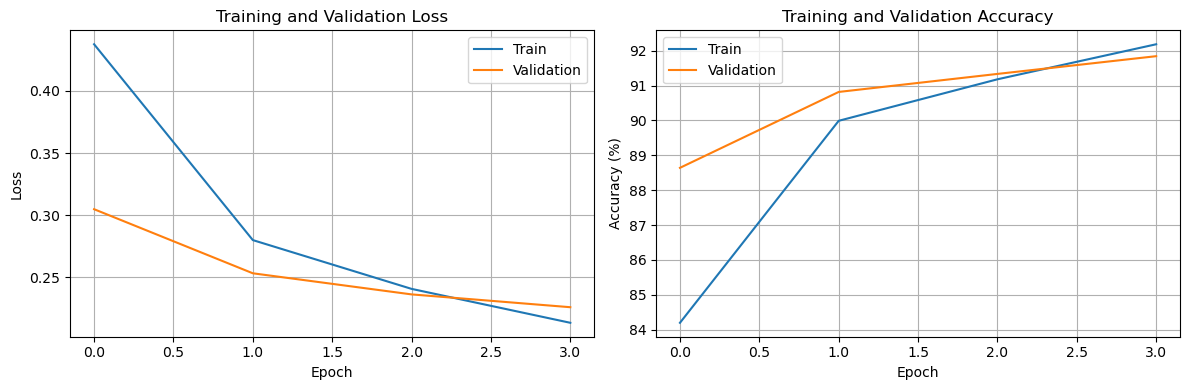

CPU times: user 16 s, sys: 16.9 s, total: 32.9 s
Wall time: 19.8 s


In [6]:
%%time
# ============================================================================
# STEP 5: Train with Train and Validation Sets
# ============================================================================
from tqdm import tqdm

print("\n" + "="*60)
print("STEP 5: Training the Model")
print("="*60)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, 100. * correct / total

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        #for images, labels in loader:
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, 100. * correct / total

# Training loop
NUM_EPOCHS = 4
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"\nTraining for {NUM_EPOCHS} epochs...")
print("-" * 60)

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_fashion_cnn.pth')

    print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("-" * 60)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()



STEP 6: Evaluating on Test Set


Validating: 100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 42.73it/s]



Test Loss: 0.2459
Test Accuracy: 91.26%

Per-class Accuracy:
----------------------------------------
T-shirt/top    : 88.90% (889/1000)
Trouser        : 97.50% (975/1000)
Pullover       : 88.30% (883/1000)
Dress          : 90.80% (908/1000)
Coat           : 88.80% (888/1000)
Sandal         : 98.70% (987/1000)
Shirt          : 69.60% (696/1000)
Sneaker        : 96.20% (962/1000)
Bag            : 97.50% (975/1000)
Ankle boot     : 96.30% (963/1000)


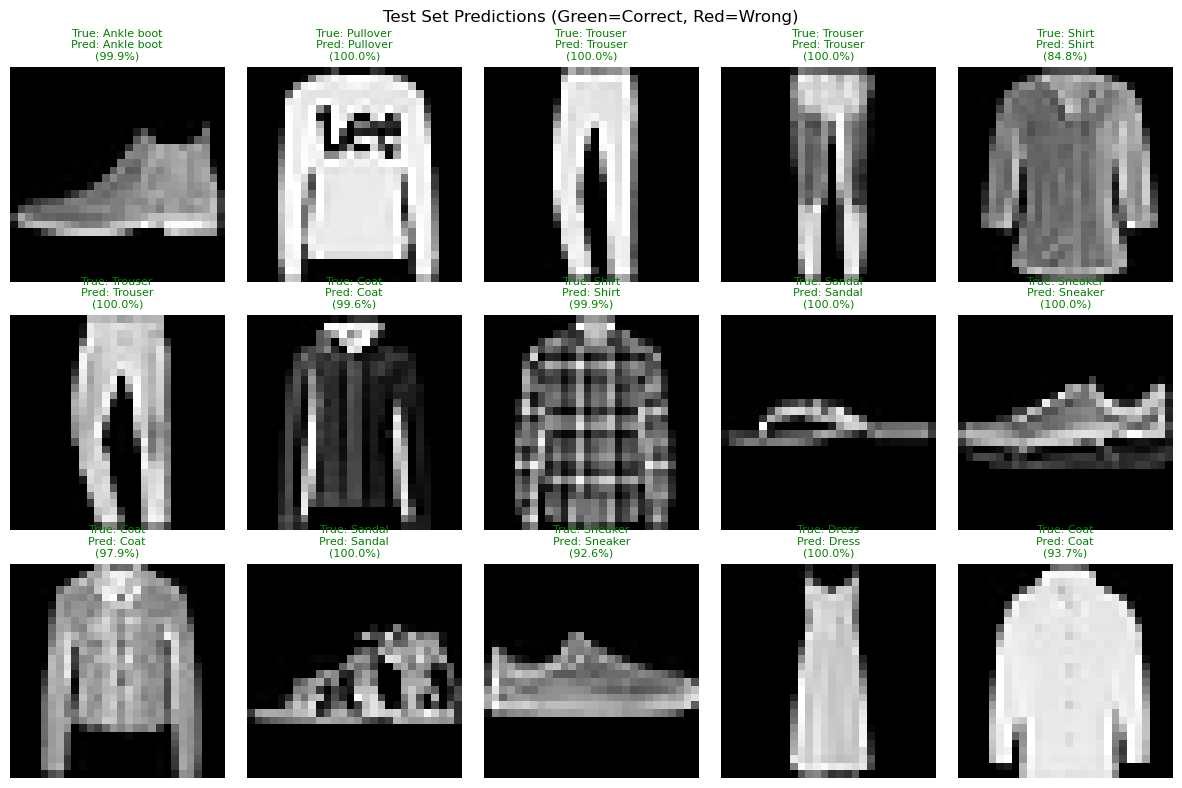

In [7]:
# ============================================================================
# STEP 6: Predict on Test Set
# ============================================================================
print("\n" + "="*60)
print("STEP 6: Evaluating on Test Set")
print("="*60)

# Load best model
model.load_state_dict(torch.load('best_fashion_cnn.pth'))

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Per-class accuracy
model.eval()
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == labels[i]:
                class_correct[label] += 1

print("\nPer-class Accuracy:")
print("-" * 40)
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"{CLASS_NAMES[i]:15s}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

# Show some test predictions
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
test_iter = iter(test_loader)
images, labels = next(test_iter)

model.eval()
with torch.no_grad():
    outputs = model(images[:15].to(device))
    _, preds = outputs.max(1)
    probs = torch.softmax(outputs, dim=1)

for idx, ax in enumerate(axes.flat):
    img = images[idx].squeeze().numpy()
    img = (img * 0.5) + 0.5  # Denormalize
    ax.imshow(img, cmap='gray')

    true_label = CLASS_NAMES[labels[idx]]
    pred_label = CLASS_NAMES[preds[idx]]
    confidence = probs[idx][preds[idx]].item() * 100

    color = 'green' if labels[idx] == preds[idx] else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)',
                 fontsize=8, color=color)
    ax.axis('off')

plt.suptitle('Test Set Predictions (Green=Correct, Red=Wrong)', fontsize=12)
plt.tight_layout()
#plt.savefig('test_predictions.png', dpi=150)
plt.show()

## Inference


STEP 7: Custom Image Prediction from URL

--- Predicting ---

Loading image from: https://raw.githubusercontent.com/elenikaxiras/CARDIO-104/main/images/boot.jpg
----- 
Original image
----------


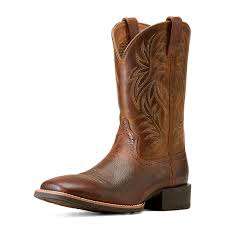

----- 
Adapted image for network
(resise to 28x28 and grayscale)
----------


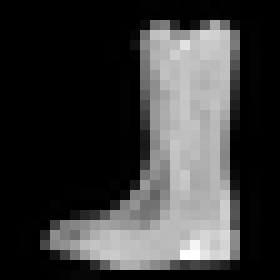


Prediction: Ankle boot (93.25% confidence)

Loading image from: https://raw.githubusercontent.com/elenikaxiras/CARDIO-104/main/images/shoe.jpg
----- 
Original image
----------


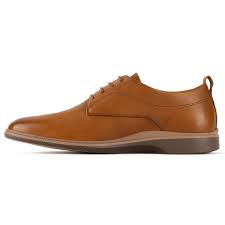

----- 
Adapted image for network
(resise to 28x28 and grayscale)
----------


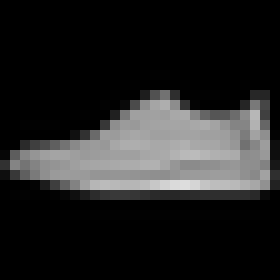


Prediction: Sneaker (99.80% confidence)


In [8]:
from IPython.display import display
import urllib.request
from PIL import Image
import requests
from io import BytesIO

# ============================================================================
# STEP 7: Predict on Custom Image from URL
# ============================================================================
print("\n" + "="*60)
print("STEP 7: Custom Image Prediction from URL")
print("="*60)

def predict_from_file(filepath, model, device):
    """
    Load a local image file and predict its Fashion MNIST class.
    """
    print(f"\nLoading image from: {filepath}")
    response = requests.get(filepath)
    img = Image.open(BytesIO(response.content))
    print('----- \nOriginal image\n----------')
    display(img)

    # Convert to grayscale if needed
    if img.mode != 'L':
        img = img.convert('L')

    # Resize to 28x28
    img = img.resize((28, 28), Image.Resampling.LANCZOS)

    # Check if image needs to be inverted
    img_array = np.array(img)
    if img_array.mean() > 127:
        img_array = 255 - img_array

    print('----- \nAdapted image for network\n(resise to 28x28 and grayscale)\n----------')
    #display(Image.fromarray(img_array))
    display(Image.fromarray(img_array).resize((280, 280),
                                              Image.Resampling.NEAREST))

    # Convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    img_tensor = transform(Image.fromarray(img_array)).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = probs.max(1)

    pred_class = CLASS_NAMES[predicted.item()]
    conf = confidence.item() * 100

    print(f"\nPrediction: {pred_class} ({conf:.2f}% confidence)")

    return pred_class, probs[0].cpu().numpy()


# Example: Try to predict from a sample URL
# Note: This uses a placeholder URL - you can replace with any fashion item image
print("\n--- Predicting ---")
# Try with a real example (boot image from a public dataset)
try:
    # Using a sample sneaker image URL
    sample_url = "https://raw.githubusercontent.com/elenikaxiras/CARDIO-104/main/images/boot.jpg"
    predict_from_file(sample_url, model, device)

except Exception as e:
    print(f"\nCouldn't download sample image: {e}")
    print("This is expected if running without internet access.")
    print("You can use the functions with your own images!")
    #predict_from_local_file(sample_url, model, device)

try:
    # Using a sample sneaker image URL
    sample_url = "https://raw.githubusercontent.com/elenikaxiras/CARDIO-104/main/images/shoe.jpg"
    predict_from_file(sample_url, model, device)

except Exception as e:
    print(f"\nCouldn't download sample image: {e}")
    print("This is expected if running without internet access.")
    print("You can use the functions with your own images!")
    #predict_from_local_file(sample_url, model, device)

## Medical dataset

In [9]:
import os, requests, hashlib
from pathlib import Path

url = "https://zenodo.org/records/10519652/files/chestmnist.npz?download=1"
out_dir = Path("data/medmnist")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "chestmnist.npz"

def download(url, dst, chunk_size=1024*1024):
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        downloaded = 0
        with open(dst, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if not chunk:
                    continue
                f.write(chunk)
                downloaded += len(chunk)
                if total:
                    print(f"\r{downloaded/total:.1%} ({downloaded/1e6:.1f}/{total/1e6:.1f} MB)", end="")
    print("\nDone:", dst)

if not out_path.exists():
    download(url, out_path)
else:
    print("Already exists:", out_path)

# quick integrity printout
h = hashlib.md5(out_path.read_bytes()).hexdigest()
print("md5:", h)
print("size (MB):", out_path.stat().st_size / 1e6)

# load + inspect
import numpy as np
d = np.load(out_path)
print("keys:", d.files)
print("train_images:", d["train_images"].shape, d["train_images"].dtype)
print("train_labels:", d["train_labels"].shape, d["train_labels"].dtype)

100.0% (82.8/82.8 MB)
Done: data/medmnist/chestmnist.npz
md5: 02c8a6516a18b556561a56cbdd36c4a8
size (MB): 82.802576
keys: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
train_images: (78468, 28, 28) uint8
train_labels: (78468, 14) uint8


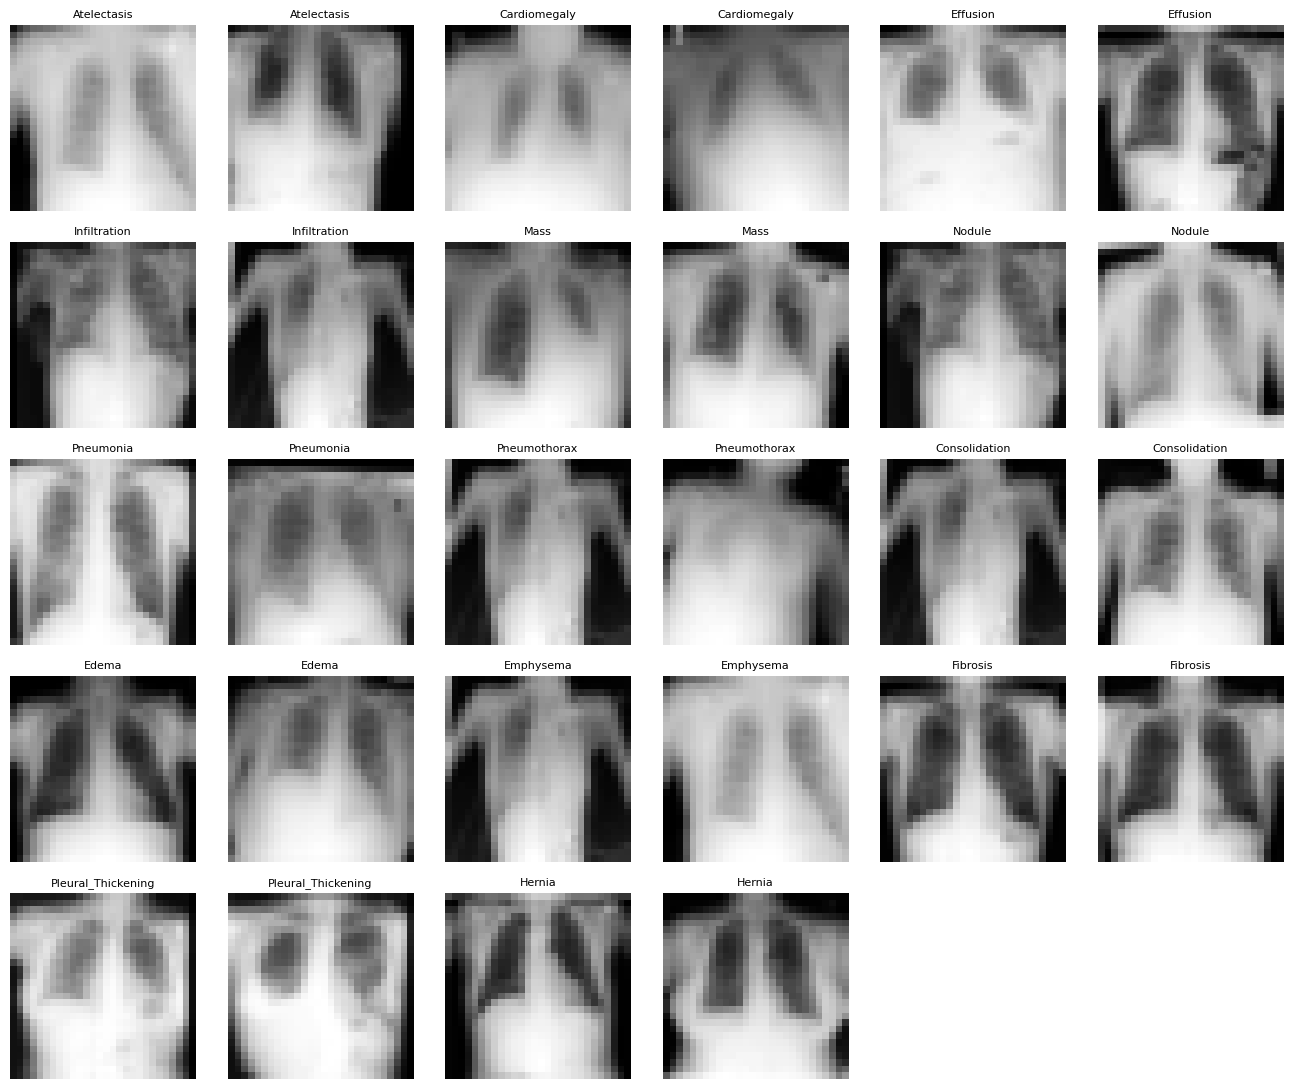

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.load("data/medmnist/chestmnist.npz")
X = data["train_images"]
y = data["train_labels"]

label_names = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

n_examples = 2
n_cols = 6
n_labels = len(label_names)

# Collect indices: 2 images per label
label_indices = []
for i in range(n_labels):
    idx = np.where(y[:, i] == 1)[0][:n_examples]
    label_indices.append(idx)

# Grid dimensions
n_rows = int(np.ceil((n_labels * n_examples) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2 * n_cols, 2.2 * n_rows))
axes = axes.flatten()

img_ptr = 0
for label, idxs in zip(label_names, label_indices):
    for j in idxs:
        ax = axes[img_ptr]
        ax.imshow(X[j], cmap="gray")
        ax.set_title(label, fontsize=8)
        ax.axis("off")
        img_ptr += 1

# Hide unused axes
for k in range(img_ptr, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd

# Load data
data = np.load("data/medmnist/chestmnist.npz")

splits = {
    "train": (data["train_images"], data["train_labels"]),
    "val":   (data["val_images"],   data["val_labels"]),
    "test":  (data["test_images"],  data["test_labels"]),
}

label_names = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

# Compute counts
rows = []
for split, (_, y) in splits.items():
    counts = y.sum(axis=0)
    total = y.shape[0]
    for label, c in zip(label_names, counts):
        rows.append({
            "split": split,
            "label": label,
            "count": int(c),
            "prevalence": float(c / total)
        })

df = pd.DataFrame(rows)

# Pivot for readability
count_table = df.pivot(index="label", columns="split", values="count")
prev_table  = df.pivot(index="label", columns="split", values="prevalence")

print("=== Label counts ===")
display(count_table.sort_index())

=== Label counts ===


split,test,train,val
label,,,
Atelectasis,2420,7996,1119
Cardiomegaly,582,1950,240
Consolidation,957,3263,447
Edema,413,1690,200
Effusion,2754,9261,1292
Emphysema,509,1799,208
Fibrosis,362,1158,166
Hernia,42,144,41
Infiltration,3938,13914,2018


In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF

print(device)
# --------- dataset ----------
class ChestMNISTNPZ(Dataset):
    def __init__(self, npz_path: str, split: str):
        d = np.load(npz_path)
        self.X = d[f"{split}_images"]          # [N, H, W] uint8
        self.y = d[f"{split}_labels"].astype(np.float32)  # [N, 14] 0/1

    def __len__(self): return len(self.X)

    def __getitem__(self, i):
        x = torch.from_numpy(self.X[i]).float() / 255.0   # [H,W] -> float
        x = x.unsqueeze(0)                                # [1,H,W]
        y = torch.from_numpy(self.y[i])                   # [14]
        return x, y

def compute_pos_weight_from_loader(loader, n_labels=14, device="cpu", eps=1e-6):
    pos = torch.zeros(n_labels, device=device)
    n = 0
    for _, y in loader:
        y = y.to(device)
        pos += y.sum(0)
        n += y.size(0)
    neg = n - pos
    return (neg + eps) / (pos + eps)

# --------- model ----------
import torchvision.models as models

class ChestMNISTResNet(nn.Module):
    def __init__(self, n_labels=14):
        super().__init__()
        m = models.resnet18(weights=None)
        m.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        m.maxpool = nn.Identity()
        m.fc = nn.Linear(512, n_labels)
        self.backbone = m

    def forward(self, x):
        return self.backbone(x)   # logits

# --------- train/val loops ----------
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_n += bs
    return total_loss / max(1, total_n)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_n = 0.0, 0
    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_n += bs
        pbar.set_postfix(loss=total_loss / max(1, total_n))
    return total_loss / max(1, total_n)

# --------- run ----------
npz_path = "data/medmnist/chestmnist.npz"

train_ds = ChestMNISTNPZ(npz_path, "train")
val_ds   = ChestMNISTNPZ(npz_path, "val")
test_ds = ChestMNISTNPZ(npz_path, "test")

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False, num_workers=0, pin_memory=False)

# compute class-imbalance weights (from train)
tmp_loader = DataLoader(train_ds, batch_size=2048, shuffle=False, num_workers=0)
pos_weight = compute_pos_weight_from_loader(tmp_loader, n_labels=14, device=device)

model = ChestMNISTResNet(n_labels=14).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

epochs = 10
for epoch in range(1, epochs + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss = evaluate(model, val_loader, criterion, device)
    print(f"epoch {epoch:02d} | train {tr_loss:.4f} | val {va_loss:.4f}")

mps


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 01 | train 1.2269 | val 1.2340


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 02 | train 1.1615 | val 1.1811


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 03 | train 1.1115 | val 1.1862


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 04 | train 1.0694 | val 1.2388


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 05 | train 1.0228 | val 1.2696


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 06 | train 0.9771 | val 1.4767


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 07 | train 0.9120 | val 1.4377


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 08 | train 0.8748 | val 1.4773


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 09 | train 0.7791 | val 1.7389


  0%|          | 0/307 [00:00<?, ?it/s]

epoch 10 | train 0.6876 | val 2.0234


In [13]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.auto import tqdm

@torch.no_grad()
def evaluate_multilabel(model, loader, device):
    model.eval()
    all_logits, all_targets = [], []

    for x, y in tqdm(loader, desc="Test"):
        x = x.to(device)
        logits = model(x)
        all_logits.append(logits.cpu())
        all_targets.append(y)

    logits = torch.cat(all_logits).numpy()
    targets = torch.cat(all_targets).numpy()

    probs = 1 / (1 + np.exp(-logits))  # sigmoid

    # Per-label AUROC
    per_label_auc = roc_auc_score(targets, probs, average=None)

    # Macro AUROC
    macro_auc = roc_auc_score(targets, probs, average="macro")

    # Micro AUROC
    micro_auc = roc_auc_score(targets, probs, average="micro")

    # Subset accuracy (exact match; usually low)
    preds = (probs >= 0.5).astype(int)
    subset_acc = accuracy_score(targets, preds)

    return {
        "macro_auc": macro_auc,
        "micro_auc": micro_auc,
        "per_label_auc": per_label_auc,
        "subset_accuracy": subset_acc,
    }

In [14]:
# run on test
test_ds = ChestMNISTNPZ("data/medmnist/chestmnist.npz", "test")
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)

metrics = evaluate_multilabel(model, test_loader, device)

print(f"Macro AUROC : {metrics['macro_auc']:.3f}")
print(f"Micro AUROC : {metrics['micro_auc']:.3f}")
print(f"Subset Acc : {metrics['subset_accuracy']:.3f}")

for name, auc in zip(label_names, metrics["per_label_auc"]):
    print(f"{name:20s} AUROC: {auc:.3f}")

Test:   0%|          | 0/44 [00:00<?, ?it/s]

Macro AUROC : 0.735
Micro AUROC : 0.792
Subset Acc : 0.139
Atelectasis          AUROC: 0.734
Cardiomegaly         AUROC: 0.844
Effusion             AUROC: 0.815
Infiltration         AUROC: 0.670
Mass                 AUROC: 0.709
Nodule               AUROC: 0.606
Pneumonia            AUROC: 0.646
Pneumothorax         AUROC: 0.754
Consolidation        AUROC: 0.755
Edema                AUROC: 0.840
Emphysema            AUROC: 0.758
Fibrosis             AUROC: 0.708
Pleural_Thickening   AUROC: 0.664
Hernia               AUROC: 0.781
